In [ ]:
from nbdev import *

In [ ]:
%nbdev_default_export solutions.lesson4

Cells will be exported to fastai_part2.solutions.lesson4,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
os.chdir(os.path.join(os.getenv('HOME'), "development", "fastai-part2"))

In [ ]:
os.pwd = os.getcwd

In [ ]:
os.pwd()

'/home/paperspace/development/fastai-part2'

In [ ]:
%nbdev_export
from solutions.lesson1 import *
from solutions.lesson2 import *
from solutions.lesson3 import *
from typing import List, Sequence, TypeVar, Generic, Callable, Tuple, Union, Optional
from types import GeneratorType
from PIL import Image
import requests
import tempfile
from io import BytesIO

In [ ]:
%nbdev_export
A = TypeVar('A')
B = TypeVar('B')

In [ ]:
%nbdev_export
class Transform(Generic[A,B]):
    _order = 0
    def __call__(self, x: A) -> B:
        raise NotImplementedError 

In [ ]:
%nbdev_export
def compose(x: A, fs: Sequence[Callable[[A], A]]) -> A: 
    sortd = sorted(fs, key=lambda x: getattr(x, '_order', 0))
    for f in sortd: x = f(x)
    return x 

In [ ]:
g = ListContainer([1,2,3])

# ItemList

We'll start by creating the ItemList class. The item list is essentially going to be a rich list representation that supports all of the normal list functionality *plus* a way to dynamically inject a sequence of callbacks during the process of fetching an item. As an exmaple, We might represent an `ImageItemList` internally as a list of paths. However, upon fetching an item, we want to open it as a PIL.Image.Image, and at training time we might want to apply several other functions to that Image object (like resizing, data augmentation, etc.) 

In [ ]:
%nbdev_export
class ItemList(ListContainer, Generic[A]):
    def __init__(self, items: List[A]):
        self.items = items 
        
    def get(self, idx: int) -> A:
        return self.items[idx]
    
    def _get(self, idx, tfms: Union[Callable[[A], A], Sequence[Callable[[A],A]]]) -> A:
        if isinstance(tfms, (GeneratorType, set)): 
            tfms = list(tfms)
        elif callable(tfms):
            tfms = [tfms]        
        x = self.get(idx)
        return compose(x, tfms)
    
    def __repr__(self): return "{}: {} items\n{}".format(self.__class__, self.__len__(), super().__repr__())

In [ ]:
class Sub1(Transform[int, int]):
    def __call__(self, x: int) -> int:
        return x - 1
    
il = ItemList([1,2,3])
assert il._get(2, [Sub1(), Sub1()]) == 1

il = ItemList(['a', 'b', 'c'])
class AddLetter:
    def __init__(self, letter):
        self.letter = letter
        
    def __call__(self, x):
        return self.letter + x
    
add_d = AddLetter('d')
add_d._order = 10
add_e = AddLetter('e')
add_e._order = 20
assert il._get(2, [add_d, add_e]) == 'edc'

add_d._order = 20
add_e._order = 10
assert il._get(2, [add_d, add_e]) == 'dec'

In [ ]:
PUPPY_PHOTO = "https://i.pinimg.com/736x/ce/53/c5/ce53c5bcd350ba856e5c53c343376fb2.jpg"

In [ ]:
photo = requests.get(PUPPY_PHOTO)
with open("puppy_file.jpg", "wb") as f:
    f.write(photo.content)

In [ ]:
%nbdev_export
class ResizeTransform(Transform[Image.Image, Image.Image]): 
    def __init__(self, px: Tuple[int, int]):
        self.px = px
    def __call__(self, img: Image):
        return img.resize(self.px)

In [ ]:
%nbdev_export
class ImageItemList(ItemList):
    def get(self, idx: int) -> Image:
        return Image.open(self.items[idx])

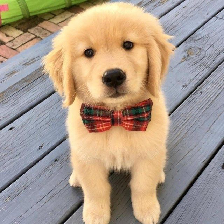

In [ ]:
img = requests.get(PUPPY_PHOTO)
i = Image.open(BytesIO(img.content)).resize((224,224))
i

In [ ]:
iil = ImageItemList(["puppy_file.jpg"])

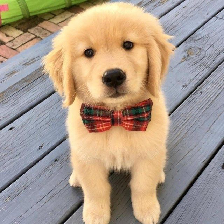

In [ ]:
iil._get(0, ResizeTransform((224,224)))

# SplitData

Next, we need to split our image list into two separate lists: one for training and one for validation. 

In [ ]:
Predicate = Callable[[A], bool]

In [ ]:
%nbdev_export
def split_by(l: List[A], *preds: Predicate[A]):
    if len(preds) == 0:
        return []
    
    t = []
    f = []
    f_a, f_bs = preds[0], preds[1:]
    for elem in l:
        if f_a(elem):
            t.append(elem)
        else:
            f.append(elem) 
    return [t, *split_by(f, *f_bs)]

In [ ]:
assert split_by([1,2,3], lambda x: x == 1, lambda x: x == 2, lambda x: x == 3) == [[1], [2], [3]]
assert split_by([], lambda x: x == 1, lambda x: x == 2) == [[], []]

In [ ]:
identity = lambda x: x

In [ ]:
fl = [(lambda x: x == i) for i in ['A', 'B', 'C']]

In [ ]:
fl[0]('A'), fl[0]('B'), fl[0]('C')

(False, False, True)

In [ ]:
fl[1]('A'), fl[1]('B'), fl[1]('C')

(False, False, True)

In [ ]:
fl[2]('A'), fl[2]('B'), fl[2]('C')

(False, False, True)

In [ ]:
j = 5
def hi():
    return j

In [ ]:
hi()

5

In [ ]:
j = 10

In [ ]:
hi()

10

In [ ]:
%nbdev_export
class Matcher(Generic[A]):
    """
    Initialized with a value `value` and optionally a function `f`.
    
    Tests equality of new values with `value`, optionally applying
    a transformation function `f` to the new values first.
    """
    def __init__(self, value: A, f: Optional[Callable[[A], A]] = None):
        self.value = value
        self.f = f or identity
        
    def __call__(self, other: A) -> bool:
        return self.value == self.f(other)
    
def map_split(l: List[A], vals: List[B], f: Callable[[A], B] = None) -> List[List[A]]:
    if f is None: f = identity
    return split_by(l, *[Matcher(v, f) for v in vals])

In [ ]:
f = lambda x: x.lower()
fl = [Matcher(x, f) for x in ['a', 'b', 'c']]
assert fl[0]('A')
assert fl[1]('B')
assert fl[2]('C')

In [ ]:
example_strs = ['ABC', 'DEF', 'HIJ']

In [ ]:
map_split(example_strs, ['ABC', 'DEF', 'HIJ'], lambda x: x)

[['ABC'], ['DEF'], ['HIJ']]

In [ ]:
map_split(example_strs, ['abc', 'def', 'hij'], lambda x: x.lower())

[['ABC'], ['DEF'], ['HIJ']]

In [ ]:
map_split(example_strs, ['abc', 'def', 'hij'], lambda x: x.lower())

[['ABC'], ['DEF'], ['HIJ']]

In [ ]:
assert map_split(example_strs, ['ABC', 'DEF', 'HIJ']) == [['ABC'], ['DEF'], ['HIJ']]
assert map_split(example_strs, ['abc', 'def', 'hij'], lambda x: x.lower()) == [['ABC'], ['DEF'], ['HIJ']]
assert map_split(example_strs, ['abc', 'def', 'hij', 'jkl'], lambda x: x.lower()) == [['ABC'], ['DEF'], ['HIJ'], []]

In [ ]:
%nbdev_export
class SplitData(Generic[A]):
    def __init__(self, train: ItemList[A], valid: ItemList[A], test: Optional[ItemList[A]] = None):
        self.train = train
        self.valid = valid
        self.test = test or []
        
    @classmethod
    def split_by_fn(cls, il: ItemList[A], f: Callable[[A], str]): #TODO: use an enum here
        il_cls = il.__class__
        train, valid, test = map_split(il, ['train', 'valid', 'test'], f)
        return cls(il_cls(train), il_cls(valid), il_cls(test))

In [ ]:
fake_items = ["some/train/item/1", "some/train/item/2", "some/valid/item/1", "some/valid/item/2"]

In [ ]:
grandparent = lambda x: x.split(os.path.sep)[1]

In [ ]:
grandparent(fake_items[0])

'train'

In [ ]:
fake_il = ItemList(fake_items)

In [ ]:
sd = SplitData.split_by_fn(fake_il, grandparent)

In [ ]:
sd.train

<class '__main__.ItemList'>: 2 items
['some/train/item/1', 'some/train/item/2']

In [ ]:
sd.valid

<class '__main__.ItemList'>: 2 items
['some/valid/item/1', 'some/valid/item/2']

In [ ]:
sd.test

[]

# LabeledData

# Databunch 

# Export

In [ ]:
from nbdev.export import notebook2script

In [ ]:
notebook2script()

Converted 00_lesson1.ipynb.
Converted 01_lesson2.ipynb.
Converted 02_lesson3.ipynb.
Converted 03_lesson4.ipynb.
